# Answering Business Questions using SQL

- Write a SQL query to extract the relevant data
- Create plots where necessary to visualize the data
- Write a short paragraph, drawing conclusions and explaining the data and/or visualizations.

We'll use the Chinook database.

## Creating Helper Functions

- We'll create some helper functions in python to save some time.
- We'll use a context manager to handle the connection to the SQLite database.

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    conn.isolation_label = None
    conn.execute(c)

def show_tables():
    q='''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

We'll write a query to find out which genres sell the most tracks in the USA.

In [3]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
    (
    SELECT inl.* FROM invoice_line inl
    INNER JOIN invoice i on inl.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
    )
    
SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


### Create a plot to show above chart

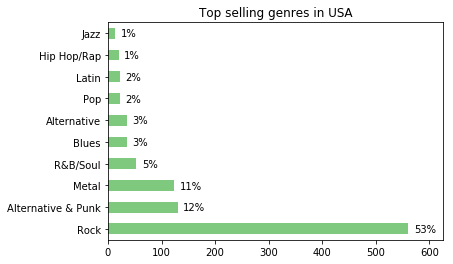

In [4]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top selling genres in USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))
    
plt.show()

Based on the chart above, we should skip the hip-hop album by the Regal

## Analyzing Employee Sales Performance

In [5]:
emp_sales_per = '''
WITH cus_sup_rep_sales AS
    (
    SELECT
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1, 2
    )
    
SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM cus_sup_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1; 
'''

run_query(emp_sales_per)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


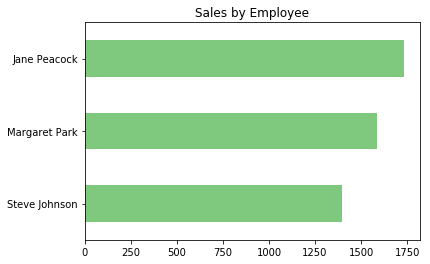

In [6]:
emp_sales = run_query(emp_sales_per)

emp_sales.set_index("employee", drop=True, inplace=True)
emp_sales.sort_values("total_sales", inplace=True)
emp_sales.plot.barh(
    legend=False,
    title='Sales by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()


While Jane has the most sales, she started the earliest. This goes for Steve as well, he has the least but he started the most recent. So it seems like sales performance is about the same for all.

## Sales Analysis by Country

For each country, analyze:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [9]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


### Visualizing sales by country

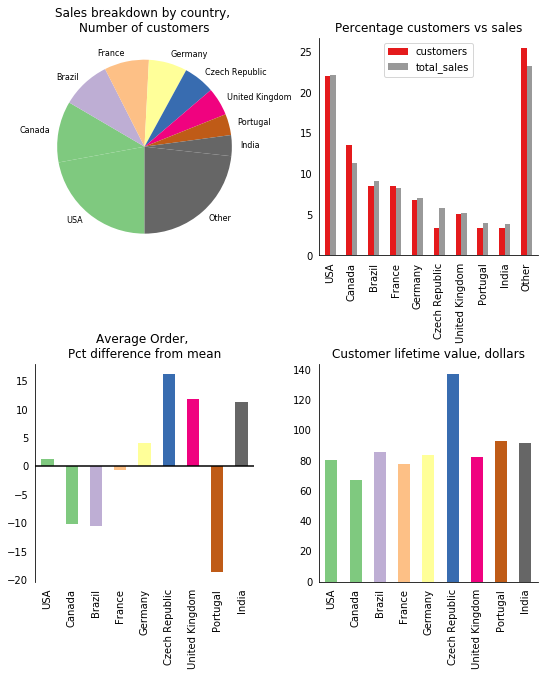

In [10]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0,1,country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales breakdown by country, \nNumber of customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
)

#top right
cvd_cols = ["customers", "total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Percentage customers vs sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
dif_from_avg = avg_order * 100 / avg_order.mean() - 100
dif_from_avg.drop("Other", inplace=True)
dif_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order, \nPct difference from mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

#bottom right 
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other", inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer lifetime value, dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()



Based on the average order value, there's a chance for growth in the Czech Republic, UK and Portugal. 

## Albums vs Individual Tracks

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [11]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
    SELECT
        il.invoice_id invoice_id,
        MIN(il.track_id) first_track_id
    FROM invoice_line il
    GROUP BY 1
    )
    
SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / 
    (
    SELECT 
        COUNT(*) FROM invoice
    ) percent
    
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t
                WHERE t.album_id = 
                    (
                    SELECT t2.album_id FROM track t2
                    WHERE t2.track_id = ifs.first_track_id
                    )
                EXCEPT
                
                 SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)


,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchase account for 19% of purchases. So if we get rid of albums, we lose 19%, therefore we should keep album sales